<center><h1>Analysing Streaming Content

## Libraries

In [1]:
import graphviz as gv
import matplotlib.pyplot as mp
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sh
import sklearn.impute as si
import sklearn.metrics as sm
import sklearn.model_selection as ms
import sklearn.tree as st
import IPython.display as ip

%matplotlib inline

## Data

In [2]:
content = pd.read_csv('Data/streaming.csv')
content

,title,year,rating,imdb,rotten,service,type,original,minutes,action,...,news,reality-tv,romance,sci-fi,short,sport,talk-show,thriller,war,western
0,The Pianist,2002,18+,8.5,95.0,amazon,movie,0,150,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,The Avengers,2012,13+,8.0,92.0,amazon,movie,0,143,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3 Idiots,2009,13+,8.4,100.0,amazon,movie,0,170,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,American Beauty,1999,18+,8.3,87.0,amazon,movie,0,122,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Once Upon a Time in the West,1968,13+,8.5,98.0,amazon,movie,0,165,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22204,Hard Knocks '17: Training Camp With The Tampa ...,2017,NaN,NaN,NaN,hbo,tv,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22205,Hijos del Carnaval,2008,NaN,NaN,NaN,hbo,tv,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22206,HBO Storybook Musicals,1987,all,NaN,NaN,hbo,tv,0,\N,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22207,Playing for Change,2018,NaN,NaN,NaN,hbo,tv,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Clustering Netflix Content

### Filtering

In [3]:
# Select Netflix content only
netflix = content[content['service']=='amazon']

### Data Cleaning

In [4]:
# Drop non-predictive features
netflix = netflix.drop('title', axis=1)
netflix = netflix.drop('service', axis=1)

# Make age rating column consistent
netflix['rating'] = netflix['rating'].replace('all', '0+')
netflix['rating'] = netflix['rating'].str[:-1].astype(float)

# Replace \N with NULL
netflix['minutes'] = netflix['minutes'].replace(r'\\N', np.nan, regex=True)

### Feature Engineering

In [5]:
# One-Hot Encoding on content type
netflix = pd.concat((netflix, pd.get_dummies(netflix['type'], prefix='type')), axis=1)
netflix = netflix.drop('type', axis=1)

In [6]:
netflix = netflix.drop('minutes', axis=1)
netflix = netflix.drop('rotten', axis=1)

In [7]:
netflix_columns = netflix.columns

### Imputation

In [8]:
imputer = si.KNNImputer()

netflix = imputer.fit_transform(netflix)

### Hierarchical Clustering

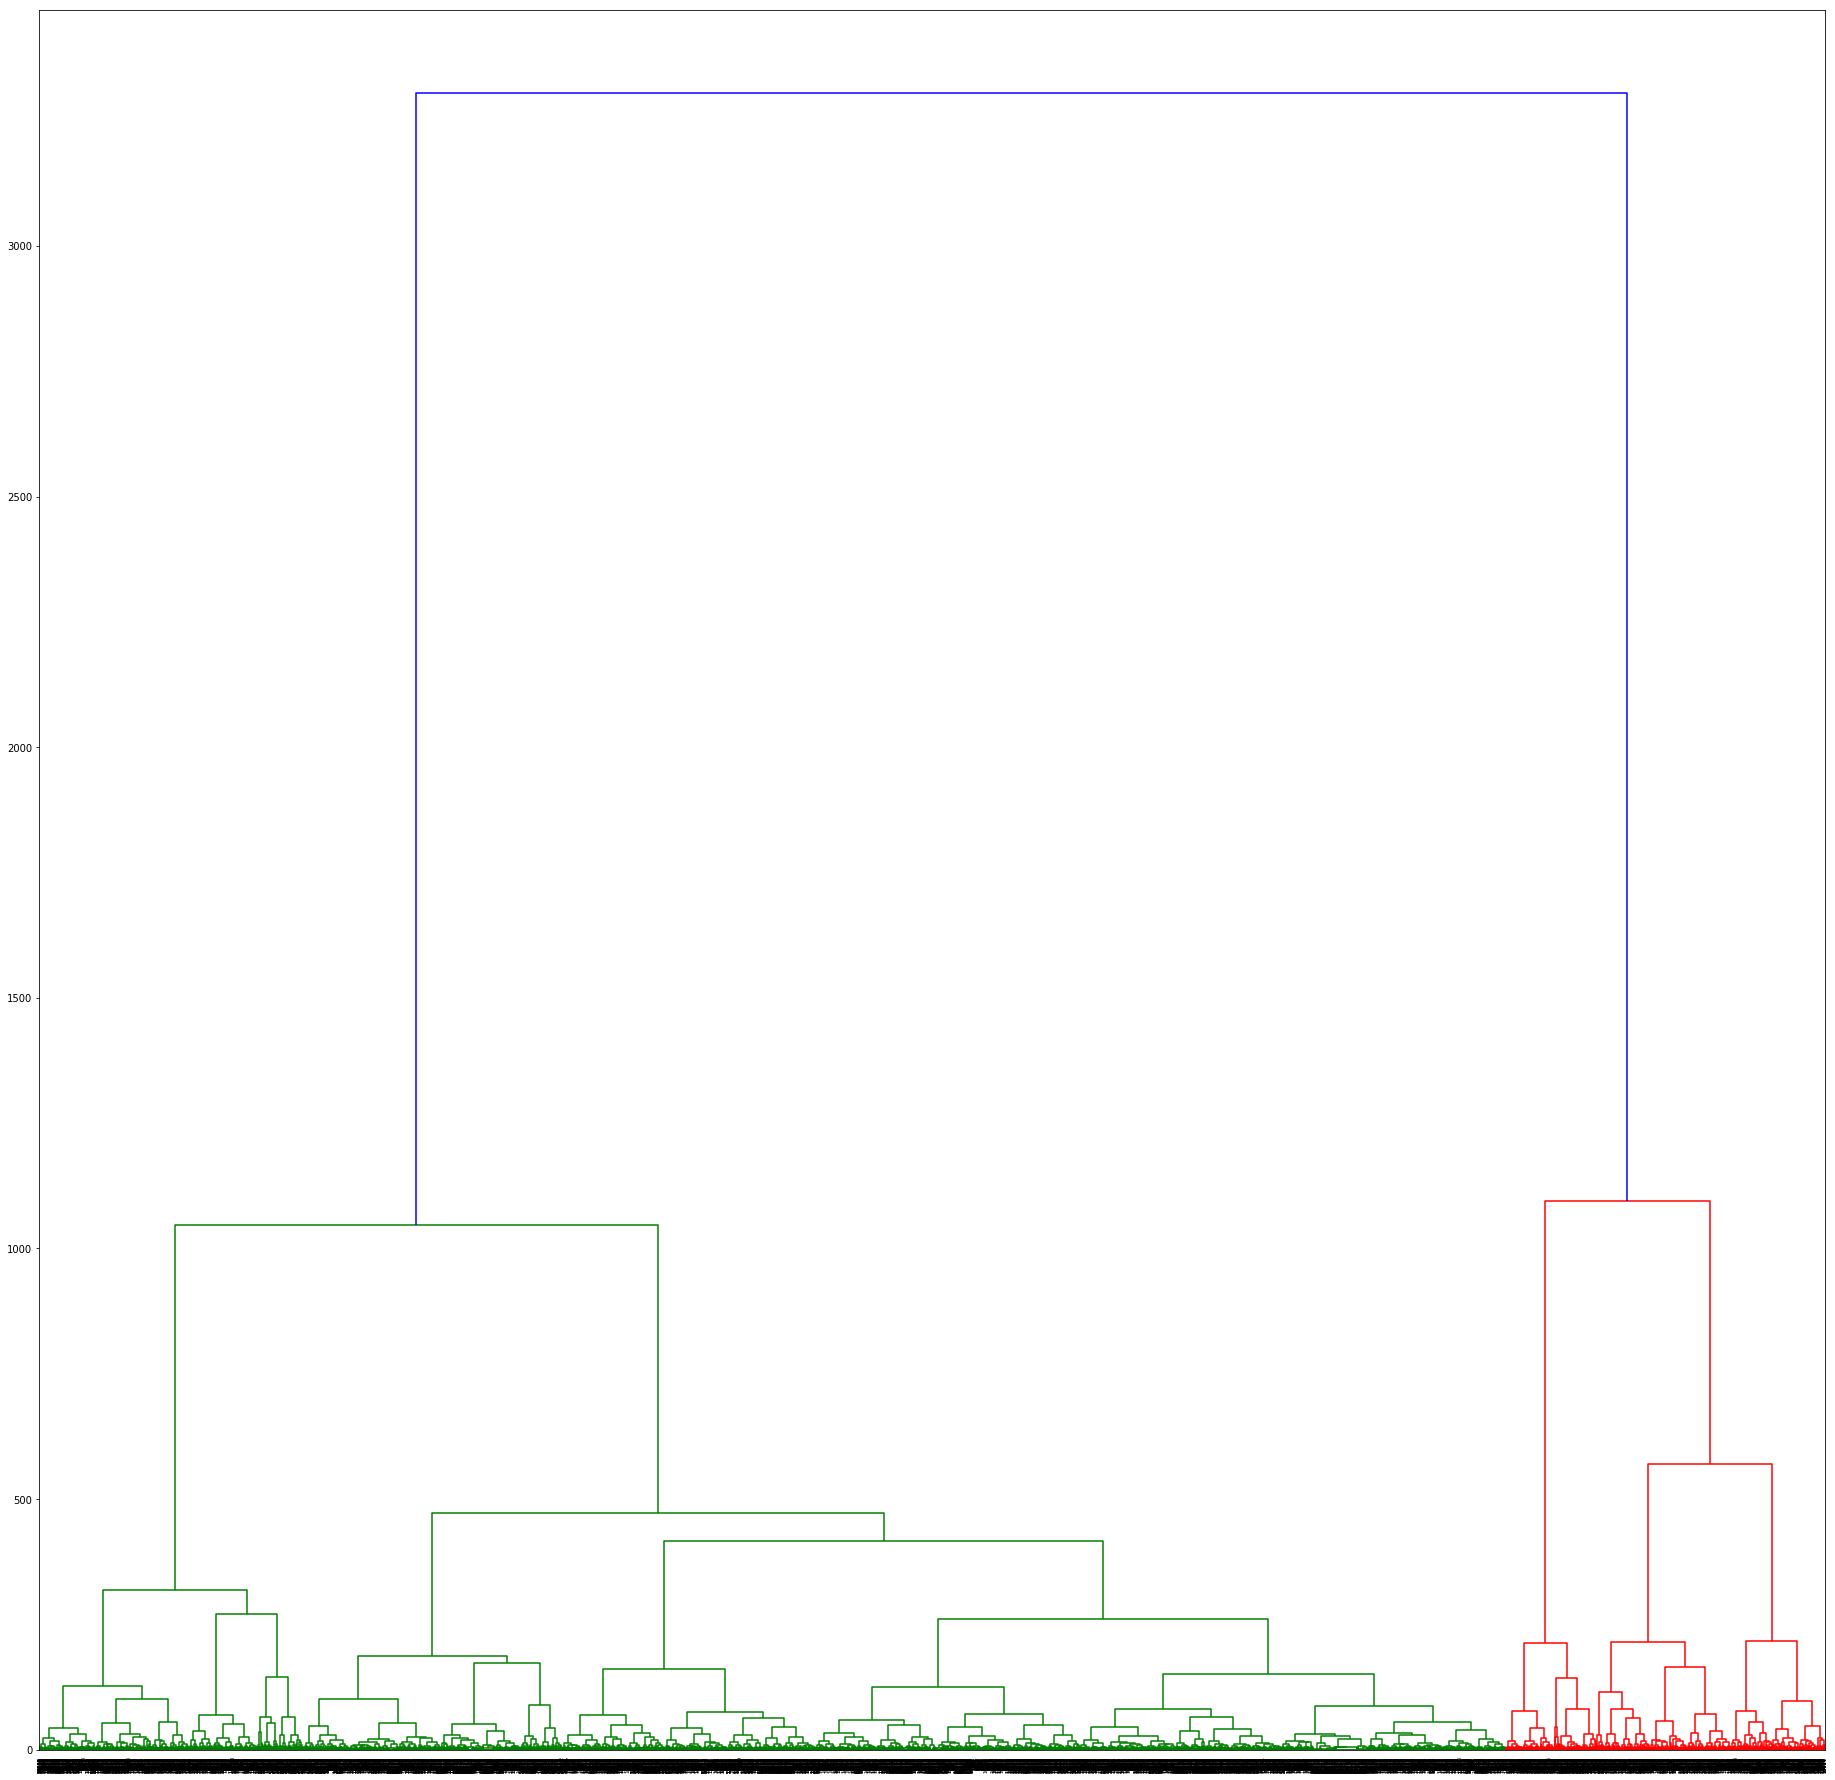

In [9]:
Z = sh.linkage(netflix, 'ward')

mp.figure(figsize=(32,32))

sh.dendrogram(Z)

mp.show()

### Choosing K

In [19]:
k = 7

cut = sh.cut_tree(Z, n_clusters=k)

### Assign cluster to each sample as a label

In [20]:
labels = list([i[0] for i in cut])
labeled_netflix = pd.DataFrame(netflix, columns=netflix_columns)
labeled_netflix['label'] = labels

## Interpreting Netflix Content

In [26]:
# Select which cluster to interpret
cluster = 6

X = labeled_netflix.drop('label', axis=1)
y = [1 if i==cluster else 0 for i in labeled_netflix['label']]

In [27]:
train_X, test_X, train_y, test_y = ms.train_test_split(X, y)

In [28]:
model = st.DecisionTreeClassifier()

# Hyperparameters
params = {
        'max_depth': [1, 2, 3, 4],
        'criterion': ['gini'],
        'min_samples_leaf': [5, 10, 25],
        'class_weight': ['balanced'],
        'ccp_alpha': [0.1, 0.01]
        }

# Grid Search
grid = ms.GridSearchCV(model, params)

# Model Fit
model = grid.fit(train_X, train_y)
model = model.best_estimator_

In [29]:
predictions_train = model.predict_proba(train_X)[:, 1]
predictions_test = model.predict_proba(test_X)[:, 1]
print('In Sample AUC:', sm.roc_auc_score(train_y, predictions_train))
print('Out of Sample AUC: ', sm.roc_auc_score(test_y, predictions_test))

In Sample AUC: 0.9670260556252495
Out of Sample AUC:  0.9621786934647312


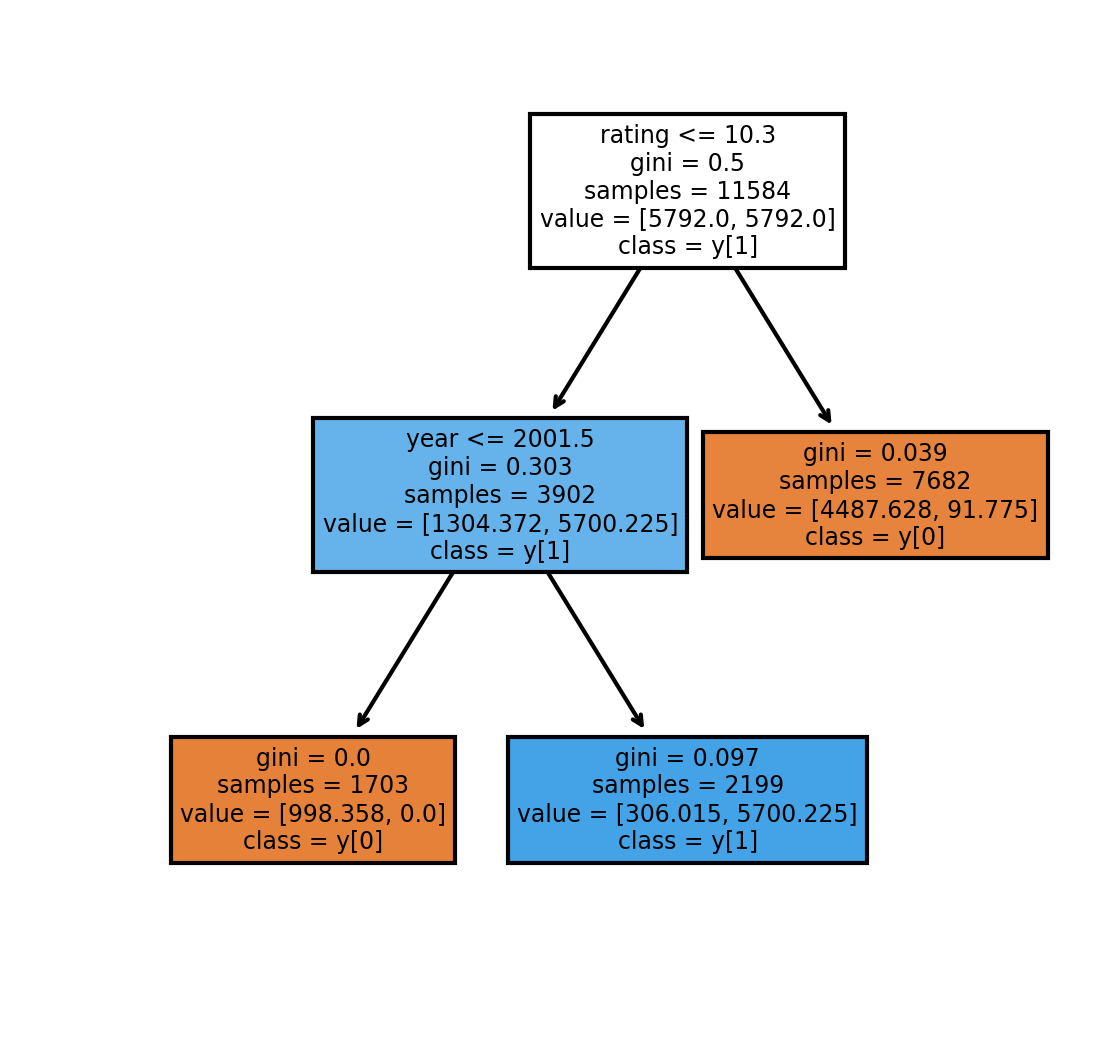

In [30]:
fig, axes = mp.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
st.plot_tree(model,
             feature_names = X.columns,
             filled = True,
             class_names=True);

In [31]:
for l in sorted(labeled_netflix['label'].unique()):
    ip.display(labeled_netflix[labeled_netflix['label']==l].describe())
    ip.display(labeled_netflix[labeled_netflix['label']==l].head())

,year,rating,imdb,original,action,adult,adventure,animation,biography,comedy,...,sci-fi,short,sport,talk-show,thriller,war,western,type_movie,type_tv,label
count,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.0,2288.000000,2288.000000,2288.000000,2288.000000,...,2288.000000,2288.000000,2288.000000,2288.0,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.0
mean,1995.797203,14.278059,5.940446,0.007430,0.225000,0.0,0.098514,0.051661,0.040559,0.258392,...,0.060752,0.006469,0.021241,0.0,0.140997,0.020542,0.011626,0.875874,0.124126,0.0
std,5.731566,4.953977,1.399316,0.085896,0.387659,0.0,0.271609,0.199884,0.179778,0.401723,...,0.221214,0.071904,0.126241,0.0,0.324158,0.129771,0.097836,0.329797,0.329797,0.0
min,1979.000000,0.000000,1.400000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1991.000000,12.800000,5.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
50%,1997.000000,16.000000,6.100000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
75%,2001.000000,18.000000,7.000000,0.000000,0.200000,0.0,0.000000,0.000000,0.000000,0.400000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
max,2005.000000,18.000000,9.500000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


,year,rating,imdb,original,action,adult,adventure,animation,biography,comedy,...,sci-fi,short,sport,talk-show,thriller,war,western,type_movie,type_tv,label
0,2002.0,18.0,8.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,1999.0,18.0,8.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
8,1988.0,18.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
14,1986.0,18.0,8.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
21,1995.0,13.0,8.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


,year,rating,imdb,original,action,adult,adventure,animation,biography,comedy,...,sci-fi,short,sport,talk-show,thriller,war,western,type_movie,type_tv,label
count,5971.000000,5971.000000,5971.000000,5971.000000,5971.000000,5971.000000,5971.000000,5971.000000,5971.000000,5971.000000,...,5971.000000,5971.000000,5971.000000,5971.000000,5971.000000,5971.000000,5971.000000,5971.000000,5971.000000,5971.0
mean,2014.929493,13.798124,5.759732,0.025791,0.128521,0.001072,0.069570,0.036007,0.044951,0.216413,...,0.047831,0.007134,0.022006,0.000636,0.159806,0.011589,0.005996,0.851784,0.148216,1.0
std,2.207317,2.781778,1.482992,0.158526,0.303451,0.031895,0.224295,0.132480,0.179304,0.364154,...,0.201643,0.072542,0.110813,0.020207,0.340252,0.099174,0.072921,0.355344,0.355344,0.0
min,2009.000000,4.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,2013.000000,11.600000,4.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0
50%,2015.000000,13.400000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0
75%,2017.000000,16.000000,6.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0
max,2020.000000,18.000000,9.300000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


,year,rating,imdb,original,action,adult,adventure,animation,biography,comedy,...,sci-fi,short,sport,talk-show,thriller,war,western,type_movie,type_tv,label
1,2012.0,13.0,8.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
6,2018.0,13.0,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
12,2016.0,14.8,8.1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
19,2017.0,18.0,7.4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
24,2017.0,18.0,7.5,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


,year,rating,imdb,original,action,adult,adventure,animation,biography,comedy,...,sci-fi,short,sport,talk-show,thriller,war,western,type_movie,type_tv,label
count,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,...,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.0
mean,2007.695116,15.112825,5.899525,0.005021,0.136741,0.000456,0.054313,0.017252,0.046098,0.237974,...,0.040712,0.005477,0.016796,0.001095,0.143679,0.022821,0.004199,0.905979,0.094021,2.0
std,2.088929,2.701391,1.498807,0.070694,0.317922,0.021364,0.204846,0.111010,0.182254,0.390270,...,0.185266,0.060191,0.116928,0.030799,0.325064,0.133890,0.061196,0.291925,0.291925,0.0
min,2002.000000,8.200000,1.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
25%,2006.000000,13.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.0
50%,2008.000000,15.800000,6.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.0
75%,2009.000000,18.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.0
max,2012.000000,18.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.0


,year,rating,imdb,original,action,adult,adventure,animation,biography,comedy,...,sci-fi,short,sport,talk-show,thriller,war,western,type_movie,type_tv,label
2,2009.0,13.0,8.4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
7,2011.0,13.0,8.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2
9,2004.0,18.0,8.2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
16,2010.0,13.0,7.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2
18,2007.0,18.0,7.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2


,year,rating,imdb,original,action,adult,adventure,animation,biography,comedy,...,sci-fi,short,sport,talk-show,thriller,war,western,type_movie,type_tv,label
count,814.000000,814.000000,814.000000,814.0,814.000000,814.0,814.000000,814.000000,814.000000,814.000000,...,814.000000,814.0,814.000000,814.0,814.000000,814.000000,814.000000,814.000000,814.000000,814.0
mean,1959.620393,6.690172,6.012432,0.0,0.162162,0.0,0.183047,0.008354,0.025061,0.185749,...,0.103686,0.0,0.006388,0.0,0.090663,0.058231,0.139803,0.926290,0.073710,3.0
std,6.175747,3.078310,1.290116,0.0,0.340816,0.0,0.361298,0.081974,0.145320,0.359846,...,0.290838,0.0,0.071933,0.0,0.267440,0.216877,0.323363,0.261459,0.261459,0.0
min,1947.000000,0.000000,1.900000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.0
25%,1954.000000,4.600000,5.200000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,3.0
50%,1959.000000,6.800000,6.200000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,3.0
75%,1965.000000,7.800000,6.900000,0.0,0.000000,0.0,0.200000,0.000000,0.000000,0.200000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,3.0
max,1971.000000,18.000000,8.700000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,3.0


,year,rating,imdb,original,action,adult,adventure,animation,biography,comedy,...,sci-fi,short,sport,talk-show,thriller,war,western,type_movie,type_tv,label
4,1968.0,13.0,8.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3
11,1963.0,9.2,8.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3
13,1950.0,7.8,8.4,0.0,0.0,0.0,0.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.2,0.0,1.0,0.0,3
15,1959.0,2.8,8.2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3
23,1960.0,7.0,8.3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3


,year,rating,imdb,original,action,adult,adventure,animation,biography,comedy,...,sci-fi,short,sport,talk-show,thriller,war,western,type_movie,type_tv,label
count,779.000000,779.000000,779.000000,779.000000,779.000000,779.0,779.000000,779.000000,779.000000,779.000000,...,779.000000,779.0,779.000000,779.0,779.000000,779.000000,779.000000,779.000000,779.000000,779.0
mean,1938.026958,2.549166,5.986059,0.003851,0.248780,0.0,0.213864,0.006418,0.008986,0.276765,...,0.007702,0.0,0.002824,0.0,0.046213,0.062644,0.144288,0.988447,0.011553,4.0
std,7.175225,2.432468,0.839273,0.061977,0.412258,0.0,0.386950,0.073193,0.088816,0.428679,...,0.081390,0.0,0.051128,0.0,0.195372,0.226471,0.334983,0.106932,0.106932,0.0
min,1901.000000,0.000000,2.700000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.0
25%,1934.000000,0.000000,5.500000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,4.0
50%,1939.000000,1.400000,6.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,4.0
75%,1943.000000,4.000000,6.600000,0.000000,0.400000,0.0,0.200000,0.000000,0.000000,0.900000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,4.0
max,1949.000000,18.000000,8.600000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,4.0


,year,rating,imdb,original,action,adult,adventure,animation,biography,comedy,...,sci-fi,short,sport,talk-show,thriller,war,western,type_movie,type_tv,label
5,1946.0,7.0,8.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4
25,1921.0,5.4,8.3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4
49,1902.0,0.0,8.2,0.0,0.0,0.0,0.2,0.0,0.0,0.2,...,0.0,0.0,0.0,0.0,0.0,0.2,0.0,1.0,0.0,4
52,1920.0,7.0,8.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4
58,1922.0,5.4,7.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4


,year,rating,imdb,original,action,adult,adventure,animation,biography,comedy,...,sci-fi,short,sport,talk-show,thriller,war,western,type_movie,type_tv,label
count,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.0,1166.000000,1166.000000,1166.000000,1166.000000,...,1166.000000,1166.0,1166.000000,1166.0,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.0
mean,1976.982847,12.844597,5.991149,0.006861,0.243911,0.0,0.107204,0.013036,0.027273,0.179245,...,0.081132,0.0,0.013379,0.0,0.154717,0.024871,0.041681,0.951973,0.048027,5.0
std,4.628115,5.378488,1.225956,0.082582,0.389907,0.0,0.287776,0.103343,0.152498,0.349442,...,0.252515,0.0,0.106892,0.0,0.332204,0.140015,0.183280,0.213916,0.213916,0.0
min,1962.000000,0.000000,1.900000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.0
25%,1973.000000,7.000000,5.200000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,5.0
50%,1977.000000,13.600000,6.100000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,5.0
75%,1981.000000,18.000000,6.900000,0.000000,0.400000,0.0,0.000000,0.000000,0.000000,0.200000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,5.0
max,1987.000000,18.000000,9.100000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,5.0


,year,rating,imdb,original,action,adult,adventure,animation,biography,comedy,...,sci-fi,short,sport,talk-show,thriller,war,western,type_movie,type_tv,label
10,1980.0,18.0,8.2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5
17,1968.0,18.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5
22,1974.0,7.0,7.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,5
37,1968.0,18.0,7.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5
50,1982.0,7.0,7.7,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5


,year,rating,imdb,original,action,adult,adventure,animation,biography,comedy,...,sci-fi,short,sport,talk-show,thriller,war,western,type_movie,type_tv,label
count,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,...,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.0
mean,2012.104157,6.272418,6.523532,0.016093,0.079750,0.001162,0.082968,0.086366,0.053643,0.190612,...,0.024676,0.008941,0.021010,0.001520,0.052481,0.017076,0.009388,0.707197,0.292803,6.0
std,3.690432,3.008529,1.261025,0.125861,0.239196,0.030770,0.260213,0.260756,0.208284,0.344288,...,0.121407,0.077475,0.128031,0.037083,0.189386,0.111478,0.080258,0.455150,0.455150,0.0
min,2001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.0
25%,2010.000000,6.400000,5.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.0
50%,2012.000000,7.000000,6.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,6.0
75%,2015.000000,7.800000,7.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,6.0
max,2020.000000,11.200000,9.300000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.0


,year,rating,imdb,original,action,adult,adventure,animation,biography,comedy,...,sci-fi,short,sport,talk-show,thriller,war,western,type_movie,type_tv,label
20,2017.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6
28,2019.0,7.0,7.7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6
56,2013.0,7.0,7.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6
61,2012.0,9.6,8.2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6
63,2010.0,7.0,8.3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6
